<a href="https://colab.research.google.com/github/arita37/mlmodels/blob/dev/mlmodels/example/timeseries_m5_deepar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#### Install MLMODELS in Colab
%%capture
!  bash <(wget -qO- https://cutt.ly/mlmodels)
!pip install pydantic==1.4 --force

### Restart Runtime AFTER Install
import os, time
os.kill(os.getpid(), 9)

In [0]:
# %matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm.autonotebook import tqdm
from pathlib import Path

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


In [0]:
########################
single_pred_length = 28
submission_pred_length = single_pred_length * 2
m5_input_path="./m5-forecasting-accuracy"
submission=True

if submission:
    pred_length = submission_pred_length
else:
    pred_length = single_pred_length


In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive/')
#Working directory

os.chdir("/content/drive/My Drive/Colab Notebooks")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
#load data
data_folder="kaggle_data"
calendar               = pd.read_csv(data_folder+'/calendar.csv')
sales_train_val        = pd.read_csv(data_folder+'/sales_train_validation.csv.zip')
sample_submission      = pd.read_csv(data_folder+'/sample_submission.csv.zip')
sell_prices            = pd.read_csv(data_folder+'/sell_prices.csv.zip')


In [0]:
cal_feat = calendar.drop(
    ['date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'event_name_1', 'event_name_2', 'd'], 
    axis=1
)
cal_feat['event_type_1'] = cal_feat['event_type_1'].apply(lambda x: 0 if str(x)=="nan" else 1)
cal_feat['event_type_2'] = cal_feat['event_type_2'].apply(lambda x: 0 if str(x)=="nan" else 1)
test_cal_feat = cal_feat.values.T
if submission:
    train_cal_feat = test_cal_feat[:,:-submission_pred_length]
else:
    train_cal_feat = test_cal_feat[:,:-submission_pred_length-single_pred_length]
    test_cal_feat  = test_cal_feat[:,:-submission_pred_length]
#### List of individual time series   Nb Series x Lenght_time_series
test_cal_feat_list  = [test_cal_feat] * len(sales_train_val)
train_cal_feat_list = [train_cal_feat] * len(sales_train_val)

We then go on to build static features (features which are constant and series-specific).
 Here, we make use of all categorical features that are provided to us as part of the M5 data.

In [0]:

"""
####### Static Features 
"""
state_ids                       = sales_train_val["state_id"].astype('category').cat.codes.values
state_ids_un , state_ids_counts = np.unique(state_ids, return_counts=True)
store_ids                       = sales_train_val["store_id"].astype('category').cat.codes.values
store_ids_un , store_ids_counts = np.unique(store_ids, return_counts=True)
cat_ids                         = sales_train_val["cat_id"].astype('category').cat.codes.values
cat_ids_un , cat_ids_counts     = np.unique(cat_ids, return_counts=True)
dept_ids                        = sales_train_val["dept_id"].astype('category').cat.codes.values
dept_ids_un , dept_ids_counts   = np.unique(dept_ids, return_counts=True)
item_ids                        = sales_train_val["item_id"].astype('category').cat.codes.values
item_ids_un , item_ids_counts   = np.unique(item_ids, return_counts=True)

In [0]:
##### Static Features 
static_cat_list          = [item_ids, dept_ids, cat_ids, store_ids, state_ids]
static_cat               = np.concatenate(static_cat_list)
static_cat               = static_cat.reshape(len(static_cat_list), len(item_ids)).T
static_cat_cardinalities = [len(item_ids_un), len(dept_ids_un), len(cat_ids_un), len(store_ids_un), len(state_ids_un)]

In [0]:
from gluonts.dataset.common import load_datasets, ListDataset
from gluonts.dataset.field_names import FieldName

In [0]:
#### Remove Categories colum
train_df            = sales_train_val.drop(["id","item_id","dept_id","cat_id","store_id","state_id"], axis=1)
train_target_values = train_df.values
if submission == True:
    test_target_values = [np.append(ts, np.ones(submission_pred_length) * np.nan) for ts in train_df.values]
else:
    #### List of individual timeseries
    test_target_values  = train_target_values.copy()
    train_target_values = [ts[:-single_pred_length] for ts in train_df.values]

In [0]:
#### Start Dates for each time series
m5_dates = [pd.Timestamp("2011-01-29", freq='D') for _ in range(len(sales_train_val))]

In [0]:
### THESE train_ds and test_ds are working currently
train_ds = ListDataset([
    {
        FieldName.TARGET            : target,
        FieldName.START             : start,
        FieldName.FEAT_DYNAMIC_REAL : fdr,
        FieldName.FEAT_STATIC_CAT   : fsc
    } for (target, start, fdr, fsc) in zip(train_target_values,   # list of individual time series
                                           m5_dates,              # list of start dates
                                           train_cal_feat_list,   # List of Dynamic Features
                                           static_cat)              # List of Static Features 
    ],     freq="D")
test_ds = ListDataset([
    {
        FieldName.TARGET            : target,
        FieldName.START             : start,
        FieldName.FEAT_DYNAMIC_REAL : fdr,
        FieldName.FEAT_STATIC_CAT   : fsc
    }
    for (target, start, fdr, fsc) in zip(test_target_values,
                                         m5_dates,
                                         test_cal_feat_list,
                                         static_cat)
], freq="D")

In [0]:
#Just to be sure, we quickly verify that dataset format is correct and that our dataset does indeed 
# contain the correct target values as well as dynamic and static features.
########################
next(iter(test_ds))


{'feat_dynamic_real': array([[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'feat_static_cat': array([1437,    3,    1,    0,    0], dtype=int32),
 'source': SourceContext(source='list_data', row=1),
 'start': Timestamp('2011-01-29 00:00:00', freq='D'),
 'target': array([ 0.,  0.,  0., ..., nan, nan, nan], dtype=float32)}

In [0]:
def gluonts_create_dynamic(df_dynamic, submission=True, single_pred_length=28, submission_pred_length=10, n_timeseries=1, transpose=1) :
    """
        N_cat x N-timseries
    """
    v = df_dynamic.values.T if transpose else df_dynamic.values
    if submission==True:
      train_cal_feat = v[:,:-submission_pred_length]
      test_cal_feat  = v
    else:
      train_cal_feat = v[:,:-submission_pred_length-single_pred_length]
      test_cal_feat  = v[:,:-submission_pred_length]

    #### List of individual time series   Nb Series x Lenght_time_series
    test_list  = [test_cal_feat] * n_timeseries
    train_list = [train_cal_feat] * n_timeseries
    
    return train_list, test_list


def gluonts_create_static(df_static, submission=1, single_pred_length=28, submission_pred_length=10, n_timeseries=1, transpose=1) :
    """
        N_cat x N-timseries
    """
    static_cat_list=[]
    static_cat_cardinalities=[]
    ####### Static Features 
    for col in df_static :
      
      v_col  = df_static[col].astype('category').cat.codes.values
      static_cat_list.append(v_col)

      _un ,_counts   = np.unique(v_col, return_counts=True)
      static_cat_cardinalities.append(len(_un))

   
    static_cat               = np.concatenate(static_cat_list)
   
    static_cat               = static_cat.reshape(len(static_cat_list), len(df_static.index)).T
    #print(static_cat.shape)
    static_cat_cardinalities=np.array(static_cat_cardinalities)
    #static_cat_cardinalities = [len(df_static[col].unique()) for col in df_static]
    return static_cat, static_cat,static_cat_cardinalities

    
def gluonts_create_timeseries(df_timeseries, submission=1, single_pred_length=28, submission_pred_length=10, n_timeseries=1, transpose=1) :
    """
        N_cat x N-timseries
    """
    #### Remove Categories colum
    train_target_values = df_timeseries.values

    if submission == True:
        test_target_values = [np.append(ts, np.ones(submission_pred_length) * np.nan) for ts in df_timeseries.values]


    else:
        #### List of individual timeseries
        test_target_values  = train_target_values.copy()
        train_target_values = [ts[:-single_pred_length] for ts in df_timeseries.values]
  
    return train_target_values, test_target_values


In [0]:

#### Start Dates for each time series
def create_startdate(date="2011-01-29", freq="1D", n_timeseries=1):
   start_dates_list = [pd.Timestamp(date, freq=freq) for _ in range(n_timeseries)]
   return start_dates_list


def gluonts_create_dataset(train_timeseries_list, start_dates_list, train_dynamic_list,  train_static_list, freq="D" ) :
    from gluonts.dataset.common import load_datasets, ListDataset
    from gluonts.dataset.field_names import FieldName
    
    train_ds = ListDataset([
        {
            FieldName.TARGET            : target,
            FieldName.START             : start,
            FieldName.FEAT_DYNAMIC_REAL : fdr,
            FieldName.FEAT_STATIC_CAT   : fsc
        } for (target, start, fdr, fsc) in zip(train_timeseries_list,   # list of individual time series
                                               start_dates_list,              # list of start dates
                                               train_dynamic_list,   # List of Dynamic Features
                                               train_static_list)              # List of Static Features 
        ],     freq=freq)
    return train_ds


In [0]:

######## Dataset generation

cal_feat = calendar.drop( ['date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'event_name_1', 'event_name_2', 'd'],  axis=1 )

cal_feat['event_type_1'] = cal_feat['event_type_1'].apply(lambda x: 0 if str(x)=="nan" else 1)
cal_feat['event_type_2'] = cal_feat['event_type_2'].apply(lambda x: 0 if str(x)=="nan" else 1)


df_dynamic    = cal_feat
df_static     = sales_train_val[["item_id","dept_id","cat_id","store_id","state_id"]]

df_timeseries = sales_train_val.drop(["id","item_id","dept_id","cat_id","store_id","state_id"], axis=1)

In [0]:
def pandas_to_gluonts_multiseries(df_timeseries, df_dynamic, df_static,pars={'submission':True,'single_pred_length':28,'submission_pred_length':10,'n_timeseries':1,'start_date':"2011-01-29",'freq':"1D"}) :
    ###         NEW CODE    ######################
    submission             = pars['submission']
    single_pred_length     = pars['single_pred_length']
    submission_pred_length = pars['submission_pred_length']
    n_timeseries           = pars['n_timeseries']
    start_date             = pars['start_date']
    freq                   = pars['freq']
    #start_date             = "2011-01-29"
    ##########################################

    train_dynamic_list, test_dynamic_list       = gluonts_create_dynamic(df_dynamic, submission=submission, single_pred_length=single_pred_length, 
                                                                         submission_pred_length=submission_pred_length, n_timeseries=n_timeseries, transpose=1)


    train_static_list, test_static_list,cardinalities          = gluonts_create_static(df_static , submission=submission, single_pred_length=single_pred_length, 
                                                                         submission_pred_length=submission_pred_length, n_timeseries=n_timeseries, transpose=0)


    train_timeseries_list, test_timeseries_list = gluonts_create_timeseries(df_timeseries, submission=submission, single_pred_length=single_pred_length, 
                                                                            submission_pred_length=submission_pred_length, n_timeseries=n_timeseries, transpose=0)

    start_dates_list = create_startdate(date=start_date, freq=freq, n_timeseries=n_timeseries)

    train_ds = gluonts_create_dataset(train_timeseries_list, start_dates_list, train_dynamic_list, train_static_list, freq=freq ) 
    test_ds  = gluonts_create_dataset(test_timeseries_list,  start_dates_list, test_dynamic_list,  test_static_list,  freq=freq ) 
    
    return train_ds, test_ds,cardinalities

In [0]:
##Set parameters of dataset
single_pred_length     = 28
submission_pred_length = single_pred_length * 2
startdate              = "2011-01-29"
freq                   = "1D"
n_timeseries           = len(sales_train_val)
pars                   ={'submission':submission,'single_pred_length':single_pred_length,'submission_pred_length':submission_pred_length,'n_timeseries':n_timeseries   ,'start_date':startdate ,'freq':freq}
train_ds, test_ds,cardinalities   = pandas_to_gluonts_multiseries(df_timeseries, df_dynamic, df_static,pars) 


In [0]:
#Just to be sure, we quickly verify that dataset format is correct and that our dataset does indeed 
# contain the correct target values as well as dynamic and static features.
########################
next(iter(test_ds))


{'feat_dynamic_real': array([[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'feat_static_cat': array([1437,    3,    1,    0,    0], dtype=int32),
 'source': SourceContext(source='list_data', row=1),
 'start': Timestamp('2011-01-29 00:00:00', freq='D'),
 'target': array([ 0.,  0.,  0., ..., nan, nan, nan], dtype=float32)}

In [0]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.distribution.neg_binomial import NegativeBinomialOutput
from gluonts.trainer import Trainer

estimator = DeepAREstimator(
    prediction_length     = pred_length,
    freq                  = "D",
    distr_output          = NegativeBinomialOutput(),
    use_feat_dynamic_real = True,
    use_feat_static_cat   = True,
    cardinality           = list(cardinalities),
    trainer               = Trainer(
    learning_rate         = 1e-3,
    epochs                = 100,
    num_batches_per_epoch = 50,
    batch_size            = 32
    )
)

predictor = estimator.train(train_ds)

INFO:root:Using CPU
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]INFO:numexpr.utils:NumExpr defaulting to 2 threads.


learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


INFO:root:Number of parameters in DeepARTrainingNetwork: 189102
100%|██████████| 50/50 [00:11<00:00,  4.48it/s, avg_epoch_loss=0.909]
INFO:root:Epoch[0] Elapsed time 11.169 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.908803
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:10<00:00,  4.80it/s, avg_epoch_loss=1.21]
INFO:root:Epoch[1] Elapsed time 10.430 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=1.210036
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:10<00:00,  4.79it/s, avg_epoch_loss=0.821]
INFO:root:Epoch[2] Elapsed time 10.451 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=0.820621
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:10<00:00,  4.78it/s, avg_epoch_loss=0.905]
INFO:root:Epoch[3] Elapsed time 10.471 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=0.904631
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [00:10<00:00,  4.80it/s, avg_epoch_loss=0.

In [0]:
from gluonts.evaluation.backtest import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,
    predictor=predictor,
    num_samples=100
)

print("Obtaining time series conditioning values ...")
tss = list(tqdm(ts_it, total=len(test_ds)))
print("Obtaining time series predictions ...")
forecasts = list(tqdm(forecast_it, total=len(test_ds)))

Obtaining time series conditioning values ...



Obtaining time series predictions ...


In [0]:

from gluonts.evaluation import Evaluator
    
if submission==False:
 
    class M5Evaluator(Evaluator):
        
        def get_metrics_per_ts(self, time_series, forecast):
            successive_diff = np.diff(time_series.values.reshape(len(time_series)))
            successive_diff = successive_diff ** 2
            successive_diff = successive_diff[:-pred_length]
            denom = np.mean(successive_diff)
            pred_values = forecast.samples.mean(axis=0)
            true_values = time_series.values.reshape(len(time_series))[-pred_length:]
            num = np.mean((pred_values - true_values)**2)
            rmsse = num / denom
            metrics = super().get_metrics_per_ts(time_series, forecast)
            metrics["RMSSE"] = rmsse
            return metrics
        
        def get_aggregate_metrics(self, metric_per_ts):
            wrmsse = metric_per_ts["RMSSE"].mean()
            agg_metric , _ = super().get_aggregate_metrics(metric_per_ts)
            agg_metric["MRMSSE"] = wrmsse
            return agg_metric, metric_per_ts
        
    
    evaluator = M5Evaluator(quantiles=[0.5, 0.67, 0.95, 0.99])
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))
    print(json.dumps(agg_metrics, indent=4))

In [0]:

"""
Converting forecasts back to M5 submission format (if submission is True)
Since GluonTS estimators return a sample-based probabilistic forecasting predictor, we first need to reduce these results to a single pred per time series. This can be done by computing the mean or median over the predicted sample paths.
"""
########################
if submission == True:
    forecasts_acc = np.zeros((len(forecasts), pred_length))
    for i in range(len(forecasts)):
        forecasts_acc[i] = np.mean(forecasts[i].samples, axis=0)


# We then reshape the forecasts into the correct data shape for submission ...
########################
if submission == True:
    forecasts_acc_sub = np.zeros((len(forecasts)*2, single_pred_length))
    forecasts_acc_sub[:len(forecasts)] = forecasts_acc[:,:single_pred_length]
    forecasts_acc_sub[len(forecasts):] = forecasts_acc[:,single_pred_length:]

"""
.. and verfiy that reshaping is consistent.
"""
########################
if submission == True:
    np.all(np.equal(forecasts_acc[0], np.append(forecasts_acc_sub[0], forecasts_acc_sub[30490])))


## Then, we save our submission into a timestamped CSV file which can subsequently be uploaded to Kaggle.
########################
if submission == True:
    import time
    sample_submission            = pd.read_csv(data_folder/sample_submission.csv')
    sample_submission.iloc[:,1:] = forecasts_acc_sub
    submission_id                = 'submission_{}.csv'.format(int(time.time()))
    sample_submission.to_csv(submission_id, index=False)


Plotting time series predictions ...


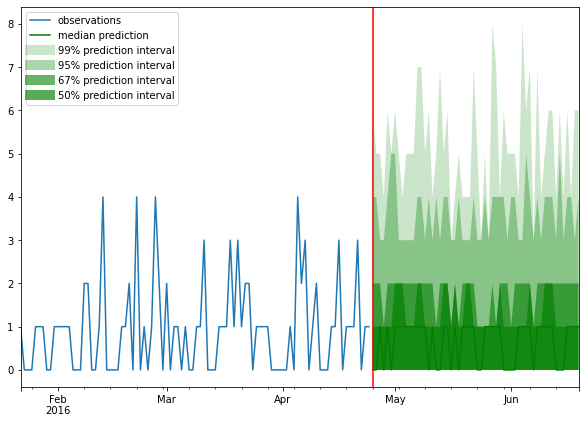

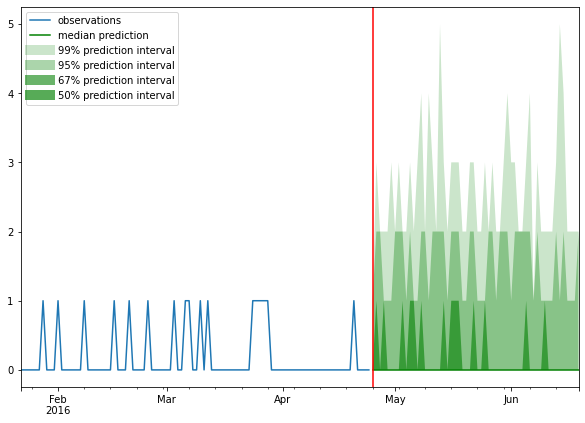

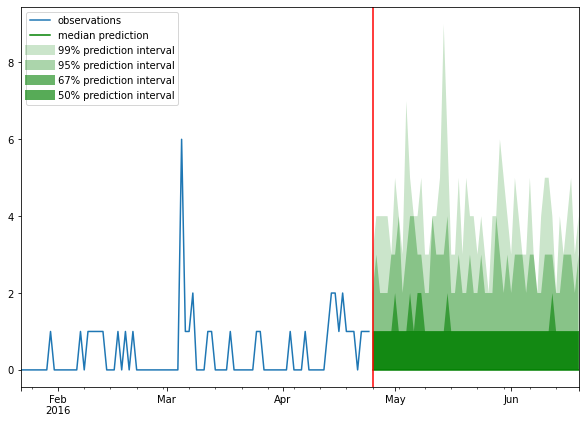

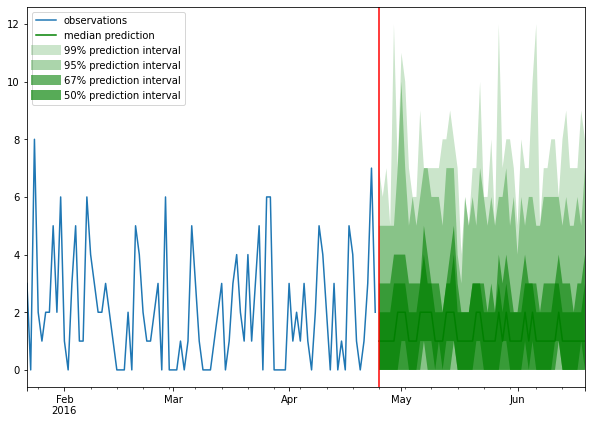

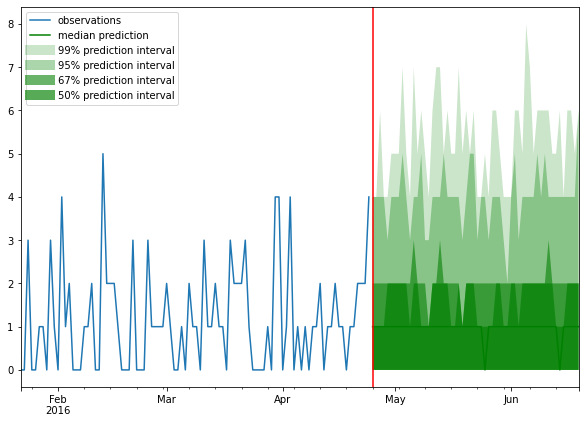

In [0]:
plot_log_path = "shared_session/timeseries_m5_benchmark/plots/"
directory = os.path.dirname(plot_log_path)
if not os.path.exists(directory):
    os.makedirs(directory)
    
def plot_prob_forecasts(ts_entry, forecast_entry, path, sample_id, inline=True):
    plot_length = 150
    prediction_intervals = (50, 67, 95, 99)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    _, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    ax.axvline(ts_entry.index[-pred_length], color='r')
    plt.legend(legend, loc="upper left")
    plt.savefig('{}forecast_{}.pdf'.format(path, sample_id))

    if inline:
        plt.show()
        plt.clf()
  
    plt.close()

print("Plotting time series predictions ...")
for i in tqdm(range(5)):
    ts_entry = tss[i]
    forecast_entry = forecasts[i]
    plot_prob_forecasts(ts_entry, forecast_entry, plot_log_path, i)